In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt5
# Add modules to the path
import sys
import os
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git\\freely_moving_photometry_analysis')
import peakutils
from matplotlib import colors, cm
from scipy.signal import decimate
import copy
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from utils.plotting import HeatMapParams
from utils.plotting import heat_map_and_mean
from utils.plotting import get_photometry_around_event
from scipy import stats
from utils.large_reward_omission_utils import plot_mean_trace_for_condition

In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\Users\francescag\AppData\Local\Continuum\miniconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [34]:
root_directory = 'W:\photometry_2AC\processed_data'
figure_dir = 'W:\\photometry_2AC\\plots\\SNL_photo21_26\\omission_large_reward_experiment'
processed_data_dir = os.path.join(root_directory, 'large_rewards_omissions_data')
block_data_file = os.path.join(processed_data_dir, 'reward_change_data_SNL_photo25.csv')
all_reward_block_data = pd.read_pickle(block_data_file)

In [49]:
all_reward_block_data['time points'].reset_index(drop=True)[0]

array([-8.    , -7.9999, -7.9998, ...,  7.9998,  7.9999,  8.    ])

In [50]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

mouse_name = 'SNL_photo25'
contra_trials = all_reward_block_data[(all_reward_block_data['mouse'] == mouse_name) & (all_reward_block_data['side'] == 'contra')]
ipsi_trials = all_reward_block_data[(all_reward_block_data['mouse'] == mouse_name) & (all_reward_block_data['side'] == 'ipsi')]
timepoints = all_reward_block_data['time points'].reset_index(drop=True)[0]
fig, ax = plt.subplots(2,1) #, figsize=(10,16))
plot_mean_trace_for_condition(ax[0], contra_trials, timepoints,
                              'reward contra', error_bar_method='sem', save_location=processed_data_dir)
lg1 = ax[0].legend(title='',bbox_to_anchor=(1., .8, .15,.2), loc='upper left')
plot_mean_trace_for_condition(ax[1],ipsi_trials, timepoints,
                              'reward ipsi', error_bar_method = 'sem', save_location=processed_data_dir)
lg2 = ax[1].legend(title='',bbox_to_anchor=(1., .8, .15,.2), loc='upper left')

plt.tight_layout()

plt.savefig(os.path.join(figure_dir, 'example_mouse{}.pdf'.format(mouse_name)))


In [54]:
font = {'size'   : 12}

matplotlib.rc('font', **font)

mouse_name = 'SNL_photo25'
all_trials = all_reward_block_data[(all_reward_block_data['mouse'] == mouse_name)]
timepoints = all_reward_block_data['time points'].reset_index(drop=True)[0]
fig, ax = plt.subplots(1,1) #, figsize=(10,16))
plot_mean_trace_for_condition(ax, all_trials, timepoints,
                              'reward', error_bar_method='sem', save_location=processed_data_dir)
lg1 = ax.legend(title='',bbox_to_anchor=(1., .8, .15,.2), loc='upper left')

plt.tight_layout()

plt.savefig(os.path.join(figure_dir, 'example_mouse{}_both_sides.pdf'.format(mouse_name)))


In [86]:
params = {'state_type_of_interest': 5,
    'outcome': 2,
    'last_outcome': 0,  # NOT USED CURRENTLY
    'no_repeats' : 0,
    'last_response': 0,
    'align_to' : 'Time end',
    'instance': -1,
    'plot_range': [-6, 6],
    'first_choice_correct': 0,
     'cue': 'None'}
test = CustomAlignedData(session_data, params, peak_quantification=False)

(116, 160000)
(137, 160000)


In [102]:
omission_trials = trial_data.loc[trial_data['State type'] == 10]['Trial num'].values
left_large_reward_trials = trial_data.loc[trial_data['State type'] == 12]['Trial num'].values
right_large_reward_trials = trial_data.loc[trial_data['State type'] == 13]['Trial num'].values
all_large_reward_trials = np.concatenate([left_large_reward_trials, right_large_reward_trials])
normal_left_reward_trials = trial_data.loc[trial_data['State type'] == 6]['Trial num'].values
normal_right_reward_trials =  trial_data.loc[trial_data['State type'] == 7]['Trial num'].values
normal_all_reward_trials =  np.concatenate([normal_left_reward_trials, normal_right_reward_trials])

In [128]:
pre_trials = normal_all_reward_trials
post_trials = all_large_reward_trials
contra_data = test.contra_data
ipsi_data = test.ipsi_data
pre_contra_trial_nums, pre_contra_trials, _ = np.intersect1d(contra_data.trial_nums, pre_trials, return_indices=True)
post_contra_trial_nums, post_contra_trials, _ = np.intersect1d(contra_data.trial_nums, post_trials, return_indices=True)
omission_contra_trial_nums, omission_contra_trials, _ =  np.intersect1d(contra_data.trial_nums, omission_trials, return_indices=True)
pre_ipsi_trial_nums, pre_ipsi_trials, _ = np.intersect1d(ipsi_data.trial_nums, pre_trials, return_indices=True)
post_ipsi_trial_nums, post_ipsi_trials, _ = np.intersect1d(ipsi_data.trial_nums, post_trials, return_indices=True)
omission_ipsi_trial_nums, omission_ipsi_trials, _ =  np.intersect1d(ipsi_data.trial_nums, omission_trials, return_indices=True)
pre_contra_traces = contra_data.sorted_traces[pre_contra_trials, :]
post_contra_traces = contra_data.sorted_traces[post_contra_trials, :]
omission_contra_traces = contra_data.sorted_traces[omission_contra_trials, :]
pre_ipsi_traces = contra_data.sorted_traces[pre_ipsi_trials, :]
post_ipsi_traces = contra_data.sorted_traces[post_ipsi_trials, :]
omission_ipsi_traces = contra_data.sorted_traces[omission_ipsi_trials, :]
pre_both_traces = np.concatenate([pre_contra_traces, pre_ipsi_traces])
post_both_traces = np.concatenate([post_contra_traces, post_ipsi_traces])
all_contra_trial_nums = np.concatenate([pre_contra_trial_nums, post_contra_trial_nums])
all_ipsi_trial_nums = np.concatenate([pre_ipsi_trial_nums, post_ipsi_trial_nums])
all_pre_trial_nums = np.concatenate([pre_ipsi_trial_nums, pre_contra_trial_nums])
all_post_trial_nums = np.concatenate([post_contra_trial_nums, post_ipsi_trial_nums])
all_trial_nums = np.concatenate([all_contra_trial_nums, all_ipsi_trial_nums])
all_contra_traces = np.concatenate([pre_contra_traces, post_contra_traces])
all_ipsi_traces = np.concatenate([pre_ipsi_traces, post_ipsi_traces])
all_traces = np.concatenate([all_contra_traces, all_ipsi_traces])
all_omission_traces = np.concatenate([omission_contra_traces, omission_ipsi_traces])
all_omission_trial_nums = np.concatenate([omission_contra_trial_nums, omission_ipsi_trial_nums])
list_traces = [all_traces[i,:] for i in range(all_traces.shape[0])]
list_omission_traces = [all_omission_traces[i,:] for i in range(all_omission_traces.shape[0])]

In [145]:
omission_data = {}
omission_data['trial number'] = all_omission_trial_nums
omission_data['side'] = np.where(np.isin(all_omission_trial_nums, omission_ipsi_trial_nums), 'ipsi', 'contra')
omission_dataf = pd.DataFrame(omission_data)
omission_dataf['traces'] = pd.Series(list_omission_traces, index=omission_dataf.index)
omission_dataf['reward'] = 'omission'

In [146]:
one_session_data = {}
ipsi_contra_labels = np.where(np.isin(all_trial_nums, all_ipsi_trial_nums), 'ipsi', 'contra')
label = 'large reward'
reward_size_labels =  np.where(np.isin(all_trial_nums, all_post_trial_nums), label, 'normal')
one_session_data['reward'] = reward_size_labels
one_session_data['trial number'] = all_trial_nums
one_session_data['side'] = ipsi_contra_labels
one_session_dataf = pd.DataFrame(one_session_data)
one_session_dataf['traces'] = pd.Series(list_traces, index=one_session_dataf.index)


In [154]:
all_reward_type_data = pd.concat([one_session_dataf, omission_dataf])
all_reward_type_data['time points'] = pd.Series([test.contra_data.time_points] *
                                                                     (len(list_traces) + len(all_omission_traces)), index=all_reward_type_data.index)

In [155]:
all_reward_type_data


,reward,trial number,side,traces,time points
0,normal,5.0,contra,"[-0.9817734531703455, -0.9816829207065246, -0....","[-8.0, -7.999899999374996, -7.999799998749992,..."
1,normal,6.0,contra,"[1.865853722580664, 1.866047412547609, 1.86624...","[-8.0, -7.999899999374996, -7.999799998749992,..."
2,normal,7.0,contra,"[0.025132066723439463, 0.024394996424457232, 0...","[-8.0, -7.999899999374996, -7.999799998749992,..."
3,normal,8.0,contra,"[-0.2029963503314099, -0.20289580001850877, -0...","[-8.0, -7.999899999374996, -7.999799998749992,..."
4,normal,9.0,contra,"[-0.7397312091759803, -0.739868591370465, -0.7...","[-8.0, -7.999899999374996, -7.999799998749992,..."
...,...,...,...,...,...
21,omission,209.0,ipsi,"[0.6167800431524404, 0.6161432487489985, 0.615...","[-8.0, -7.999899999374996, -7.999799998749992,..."
22,omission,216.0,ipsi,"[0.06834632726128184, 0.06809730703632784, 0.0...","[-8.0, -7.999899999374996, -7.999799998749992,..."
23,omission,226.0,ipsi,"[1.029948871520588, 1.0293034430467867, 1.0286...","[-8.0, -7.999899999374996, -7.999799998749992,..."
24,omission,228.0,ipsi,"[2.182608559302309, 2.1830446813187545, 2.1834...","[-8.0, -7.999899999374996, -7.999799998749992,..."


In [96]:
def find_contra_and_ipsi_traces_for_criterion(pre_trials, post_trials, contra_data, ipsi_data, label='large reward'):
    _, pre_contra_trials, _ = np.intersect1d(contra_data.trial_nums, pre_trials, return_indices=True)
    _, post_contra_trials, _ = np.intersect1d(contra_data.trial_nums, post_trials, return_indices=True)
    _, pre_ipsi_trials, _ = np.intersect1d(ipsi_data.trial_nums, pre_trials, return_indices=True)
    _, post_ipsi_trials, _ = np.intersect1d(ipsi_data.trial_nums, post_trials, return_indices=True)
    pre_contra_traces = contra_data.sorted_traces[pre_contra_trials, :]
    post_contra_traces = contra_data.sorted_traces[post_contra_trials, :]
    pre_ipsi_traces = contra_data.sorted_traces[pre_ipsi_trials, :]
    post_ipsi_traces = contra_data.sorted_traces[post_ipsi_trials, :]
    pre_both_traces = np.concatenate([pre_contra_traces, pre_ipsi_traces])
    post_both_traces = np.concatenate([post_contra_traces, post_ipsi_traces])
    return pre_contra_traces, post_contra_traces, pre_ipsi_traces, post_ipsi_traces, pre_both_traces, post_both_traces

In [103]:
 pre_contra_traces, post_contra_traces, pre_ipsi_traces, post_ipsi_traces, pre_both_traces, post_both_traces = find_contra_and_ipsi_traces_for_criterion(
   normal_all_reward_trials, all_large_reward_trials, test.contra_data, test.ipsi_data )

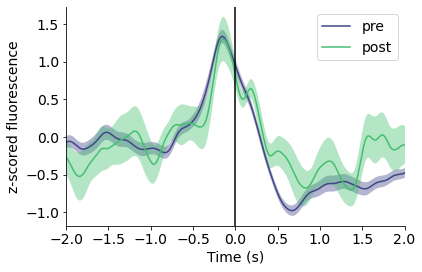

In [104]:
plot_comparison_trace(pre_contra_traces, post_contra_traces)

In [81]:
def plot_comparison_trace(pre_traces, post_traces):    
    font = {'size'   : 14}
    matplotlib.rc('font', **font)

    fig, axs1 = plt.subplots(1,1)
    colours = cm.viridis(np.linspace(0.2, 0.7, 2))
    pre_mean_trace = decimate(np.mean(pre_traces, axis=0), 10)
    post_mean_trace = decimate(np.mean(post_traces, axis=0), 10)
    time_points = decimate(test.contra_data.time_points, 10)
    traces = decimate(test.contra_data.sorted_traces, 10)
    axs1.plot(time_points, pre_mean_trace, label='pre', color=colours[0])
    pre_error_bar_lower, pre_error_bar_upper = calculate_error_bars(pre_mean_trace,
                                                            decimate(pre_traces, 10),
                                                            error_bar_method='sem')

    axs1.fill_between(time_points, pre_error_bar_lower, pre_error_bar_upper, alpha=0.4, linewidth=0, color=colours[0])
    axs1.plot(time_points,post_mean_trace, label='post', color=colours[1])
    post_error_bar_lower, post_error_bar_upper = calculate_error_bars(post_mean_trace,
                                                            decimate(post_traces, 10),
                                                            error_bar_method='sem')
    axs1.fill_between(time_points, post_error_bar_lower, post_error_bar_upper, alpha=0.4, linewidth=0, color=colours[1])
    axs1.set_xlim([-2,2])
    axs1.axvline([0], color='k')
    axs1.set_ylabel('z-scored fluorescence')
    axs1.set_xlabel('Time (s)')

    axs1.spines['right'].set_visible(False)
    axs1.spines['top'].set_visible(False)
    plt.legend()
    plt.tight_layout()
